In [1]:
import uproot
import awkward as ak
from coffea import nanoevents
from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup

ak.behavior.update(vector.behavior)

import pickle, json, gzip
import numpy as np

from typing import Optional, List, Dict
from copy import copy

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from tqdm import tqdm
import fastjet

# import jetnet

import os

import corrections
import correctionlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plot_dir = "../../../plots/ScaleFactors/Feb1"
_ = os.system(f"mkdir -p {plot_dir}")


In [4]:
events = nanoevents.NanoEventsFactory.from_root(
    "/eos/uscms/store/user/lpcpfnano/cmantill/v2_3/2017/HH_gen/GluGluToHHTobbVV_node_cHHH1_TuneCP5_13TeV-powheg-pythia8/GluGluToHHTobbVV_node_cHHH1/221017_221918/0000/nano_mc2017_100.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()


/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1994 branches) at 0x7f71aef0cb50>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1994 branches) at 0x7f71aef0cb50>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1994 branches) at 0x7f71aef0cb50>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Eve

### HHbbVV Pre-selection

In [5]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret


def add_selection(
    name: str,
    sel: np.ndarray,
    selection: PackedSelection,
    cutflow: dict = None,
    isData: bool = False,
    signGenWeights: ak.Array = None,
):
    """adds selection to PackedSelection object and the cutflow dictionary"""
    selection.add(name, sel)
    if cutflow is not None:
        cutflow[name] = (
            np.sum(selection.all(*selection.names))
            if isData
            # add up sign of genWeights for MC
            else np.sum(signGenWeights[selection.all(*selection.names)])
        )




In [6]:
isData = False
signGenWeights = None if isData else np.sign(events["genWeight"])
n_events = len(events) if isData else int(np.sum(signGenWeights))
selection = PackedSelection()

cutflow = {}
cutflow["all"] = len(events)

preselection_cut_vals = {"pt": 250, "msd": 20}
num_jets = 2

fatjets = corrections.get_jec_jets(events, "2018")

preselection_cut = np.prod(
    pad_val(
        (events.FatJet.pt > preselection_cut_vals["pt"])
        * (events.FatJet.msoftdrop > preselection_cut_vals["msd"]),
        num_jets,
        False,
        axis=1,
    ),
    axis=1,
)

add_selection(
    "preselection",
    preselection_cut.astype(bool),
    selection,
    cutflow,
    isData,
    signGenWeights,
)

### Gen Matching

In [7]:
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
c_PDGID = 4
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
Y_PDGID = 35

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

In [8]:
# finding the two gen higgs
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]

# saving 4-vector info
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}

higgs_children = higgs.children

# saving whether H->bb or H->VV
GenHiggsVars["GenHiggsChildren"] = abs(higgs_children.pdgId[:, :, 0]).to_numpy()

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HVV = higgs[ak.sum(is_VV, axis=2) == 2]

# checking that there are 2 b's and 2 V's
has_bb = ak.sum(ak.flatten(is_bb, axis=2), axis=1) == 2
has_VV = ak.sum(ak.flatten(is_VV, axis=2), axis=1) == 2

# only select events with 2 b's and 2 V's
add_selection("has_bbVV", has_bb * has_VV, selection, cutflow, False, signGenWeights)

# saving bb and VV 4-vector info
bb = ak.flatten(higgs_children[is_bb], axis=2)
VV = ak.flatten(higgs_children[is_VV], axis=2)

# have to pad to 2 because of some 4V events
GenbbVars = {
    f"Genbb{key}": pad_val(bb[var], 2, FILL_NONE_VALUE, axis=1)
    for (var, key) in skim_vars.items()
}

# selecting only up to the 2nd index because of some 4V events
# (doesn't matter which two are selected since these events will be excluded anyway)
GenVVVars = {f"GenVV{key}": VV[var][:, :2].to_numpy() for (var, key) in skim_vars.items()}

# checking that each V has 2 q children
VV_children = VV.children

quarks = abs(VV_children.pdgId) <= b_PDGID
all_q = ak.all(ak.all(quarks, axis=2), axis=1)
add_selection("all_q", all_q, selection, cutflow, False, signGenWeights)

V_has_2q = ak.count(VV_children.pdgId, axis=2) == 2
has_4q = ak.values_astype(ak.prod(V_has_2q, axis=1), np.bool)
add_selection("has_4q", has_4q, selection, cutflow, False, signGenWeights)

# saving 4q 4-vector info
Gen4qVars = {
    f"Gen4q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(
                ak.pad_none(VV_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True
            ),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}

/tmp/ipykernel_7909/955264449.py:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  has_4q = ak.values_astype(ak.prod(V_has_2q, axis=1), np.bool)


In [9]:
select = selection.all(*selection.names)
presel_events = events[selection.all(*selection.names)]

In [10]:
Hbb = higgs[ak.sum(is_bb, axis=2) == 2]
HVV = higgs[ak.sum(is_VV, axis=2) == 2]

Hbb = ak.pad_none(Hbb, 1, axis=1, clip=True)[:, 0]
HVV = ak.pad_none(HVV, 1, axis=1, clip=True)[:, 0]

In [11]:
bbdr = fatjets[:, :2].delta_r(Hbb)
vvdr = fatjets[:, :2].delta_r(HVV)

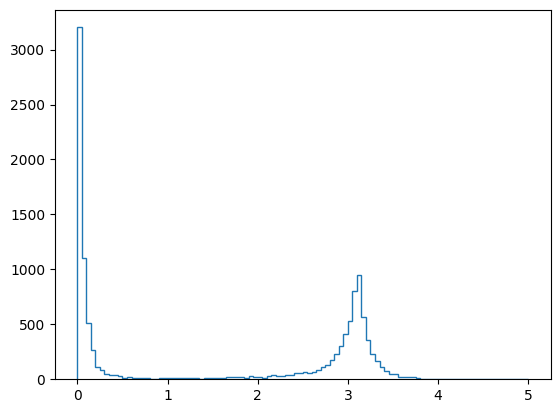

In [64]:
_ = plt.hist(np.array(bbdr[select]).reshape(-1), np.linspace(0, 5, 101), histtype='step')

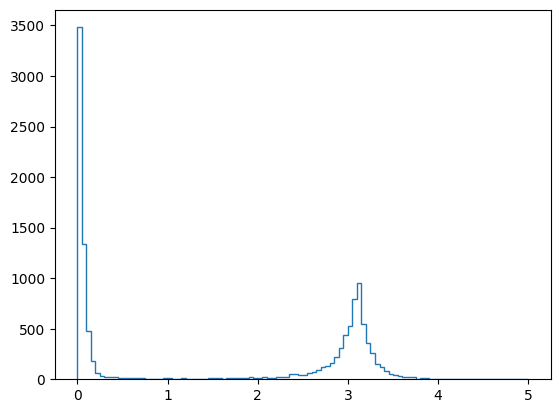

In [66]:
_ = plt.hist(np.array(vvdr[select]).reshape(-1), np.linspace(0, 5, 101), histtype='step')

In [25]:
match_dR = 0.8
Hbb_match = bbdr <= match_dR
HVV_match = vvdr <= match_dR

# overlap removal - in the case where fatjet is matched to both, match it only to the closest Higgs
Hbb_match = (Hbb_match * ~HVV_match) + (bbdr <= vvdr) * (Hbb_match * HVV_match)
HVV_match = (HVV_match * ~Hbb_match) + (bbdr > vvdr) * (Hbb_match * HVV_match)

In [45]:
VVJets = ak.pad_none(fatjets[HVV_match], 1, axis=1)[:, 0]
quarkdrs = ak.flatten(VVJets.delta_r(VV_children), axis=2)
num_prongs = ak.sum(quarkdrs < match_dR, axis=1)

In [58]:
GenMatchingVars = {
    "ak8FatJetHbb": pad_val(Hbb_match, 2, FILL_NONE_VALUE, axis=1),
    "ak8FatJetHVV": pad_val(HVV_match, 2, FILL_NONE_VALUE, axis=1),
    "ak8FatJetHVVNumProngs": ak.fill_none(num_prongs, -99999).to_numpy(),
}

In [ ]:
GenMatchingVars[]

In [54]:
bb[select][1]

<GenParticleArray [GenParticle, GenParticle] type='2 * ?genParticle'>

In [51]:
ak.flatten(VV_children, axis=2)[select][0]

<GenParticleArray [GenParticle, ... GenParticle] type='4 * ?genParticle'>

In [23]:
Hbb_match[select]

<Array [[False, True], ... [False, True]] type='5925 * option[var * bool]'>

In [21]:
HVV_match[select]

<Array [[True, False], ... [True, False]] type='5925 * option[var * bool]'>

In [ ]:
(Hbb_match * HVV_match)[select]

In [24]:
ak.sum((Hbb_match * HVV_match)[select])

0

In [ ]:
jet_idx = 0

ak8_pfcands = presel_events.FatJetPFCands
ak8_pfcands = ak8_pfcands[ak8_pfcands.jetIdx == jet_idx]
pfcands = presel_events.PFCands[ak8_pfcands.pFCandsIdx]

pfcands_vector_ptetaphi = ak.Array(
    [
        [{kin_key: cand[kin_key] for kin_key in skim_vars} for cand in event_cands]
        for event_cands in merged_pfcands
    ],
    with_name="PtEtaPhiMLorentzVector",
)
